# ディスコ 株価（日足）

In [1]:
import sys
import os

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

try:
    __file__
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    from pathlib import Path
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '..'))

from funcs.technical import psar

In [2]:
symbol = '6146.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-05 00:00:00+09:00,36384.687811,36623.929594,34799.711000,35028.984375,5882200,0.0,0.0
2024-09-06 00:00:00+09:00,35347.972240,35467.593128,33912.521591,34540.531250,4079900,0.0,0.0
2024-09-09 00:00:00+09:00,31749.379154,33623.439839,31629.758259,33463.945312,4899600,0.0,0.0
2024-09-10 00:00:00+09:00,33264.575315,33972.332237,32237.829359,33523.753906,4876300,0.0,0.0
2024-09-11 00:00:00+09:00,33713.156243,34181.671424,32367.421147,32915.683594,4551400,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-27 00:00:00+09:00,41500.000000,42290.000000,41250.000000,41900.000000,3363000,0.0,0.0
2025-02-28 00:00:00+09:00,38500.000000,38500.000000,37060.000000,37570.000000,4352500,0.0,0.0
2025-03-03 00:00:00+09:00,38320.000000,38640.000000,37770.000000,38400.000000,3119800,0.0,0.0


## 日足チャートとパラボリック SAR

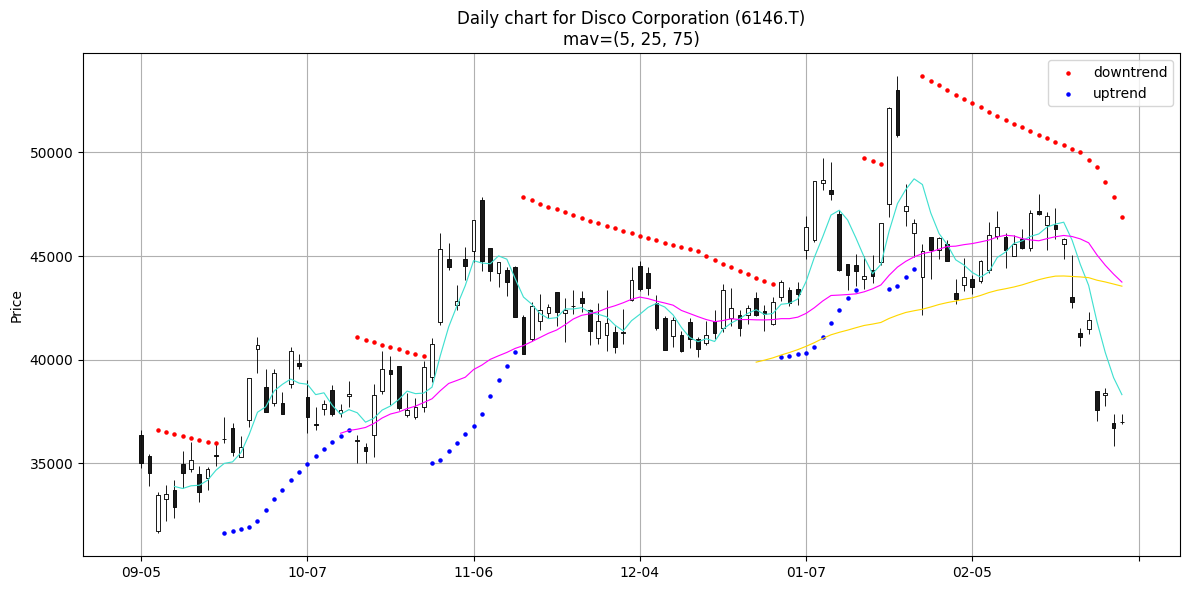

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_6146.png')
plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-03-04 00:00:00+09:00    36730.0
2025-03-05 00:00:00+09:00    37000.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-03-04 00:00:00+09:00      NaN
2025-03-05 00:00:00+09:00    270.0
Name: Close, dtype: float64